In [1]:
from matplotlib import pyplot as plt
import numpy as np

import lmfit

import RSI_utils
from RSI_utils import common_entries

# Load in data

In [2]:
real_data_dir = 'data/measured_data'
simulated_data_dir = 'data/zenodo_data/simulated_data'

real_data = RSI_utils.load_data(real_data_dir)
simulated_data = RSI_utils.load_data(simulated_data_dir)

# Clean/Process data

(this part may be taken out based on if we decide to upload the data already cleaned and processed)

In [3]:
for distance, real_df, simulated_df, carbon_energy_cutoff in common_entries(real_data, simulated_data, RSI_utils.carbon_energy_cutoffs):
    # filter energy
    real_df = real_df.query(f'{carbon_energy_cutoff[0]} < energy < {carbon_energy_cutoff[1]}')
    simulated_df = simulated_df.query(f'{RSI_utils.simulated_energy_cutoff[0]} < energy < {RSI_utils.simulated_energy_cutoff[1]}')
    # add noise to simulated dt
    simulated_df['dt'] = RSI_utils.add_noise(simulated_df['dt'], RSI_utils.time_jitter)
    # reconstruct XYZ
    simulated_df = RSI_utils.calcXYZ(simulated_df, t_offset_labr=0, Z_alpha=0.06)
    # save processed DataFrames
    real_data[distance] = real_df
    simulated_data[distance] = simulated_df

<ipython-input-3-2106417cbbea>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simulated_df['dt'] = RSI_utils.add_noise(simulated_df['dt'], RSI_utils.time_jitter)


# Fit the relationship between Z_alpha and t_offset

In order to fit everything at once, we need to have a fast way to get the correct t_offset for the Z_alpha we have choosen. Previously we had just fit these two parameters, but there should be a nice way to model their relationship. Let's start by gathering a few data points using our old curve fitting way. 

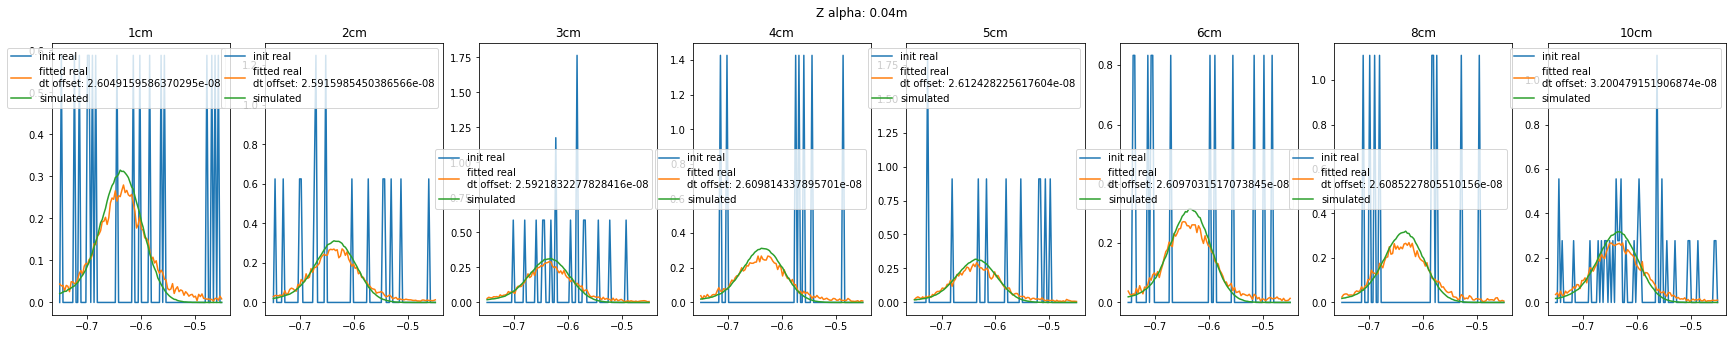

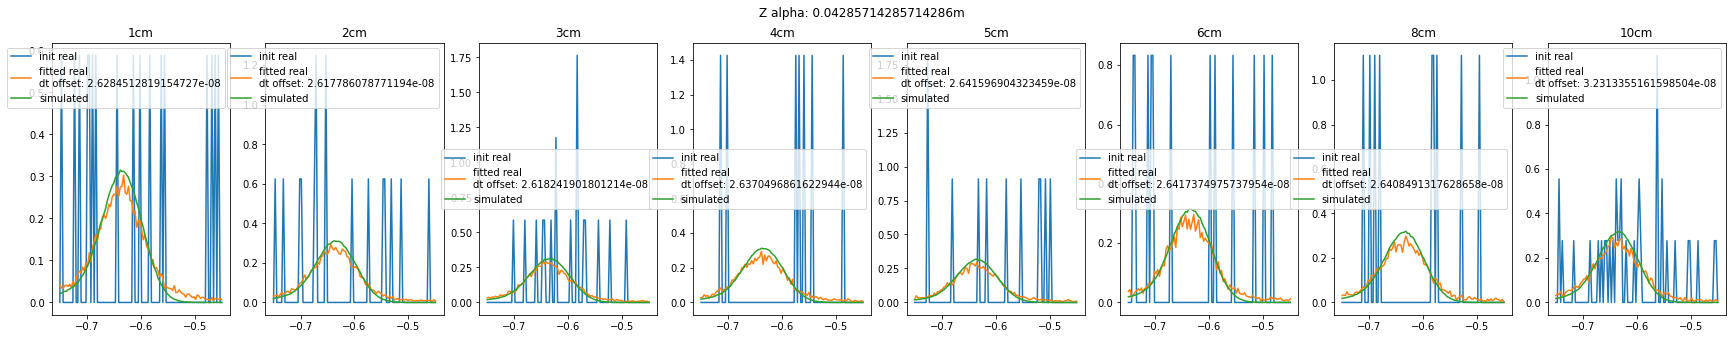

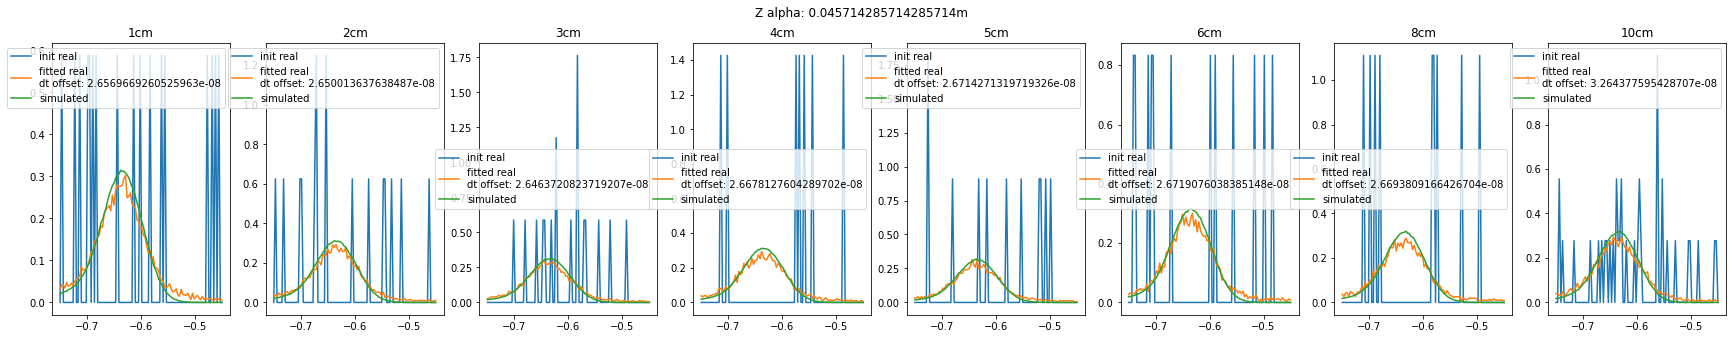

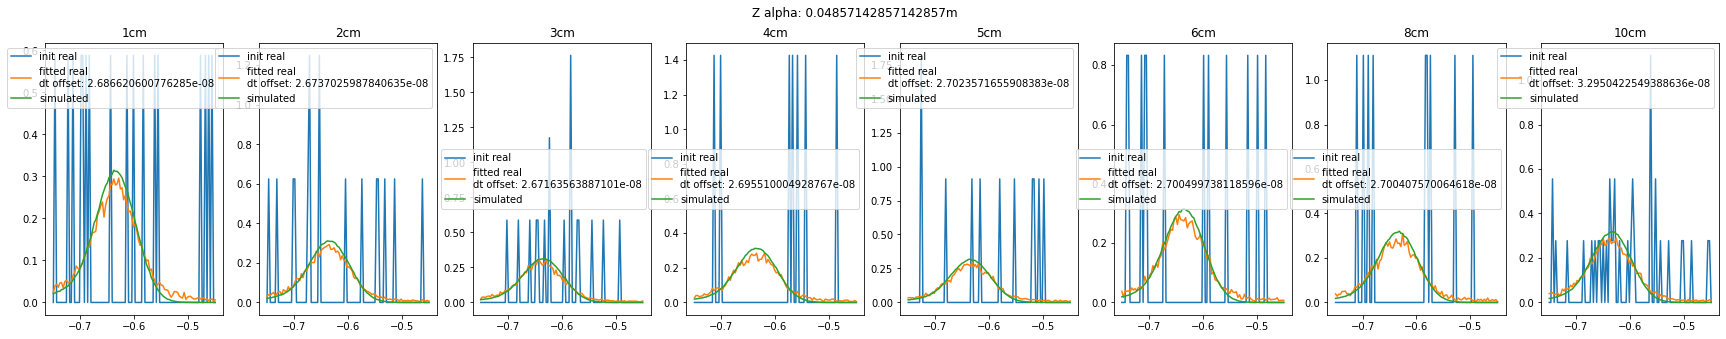

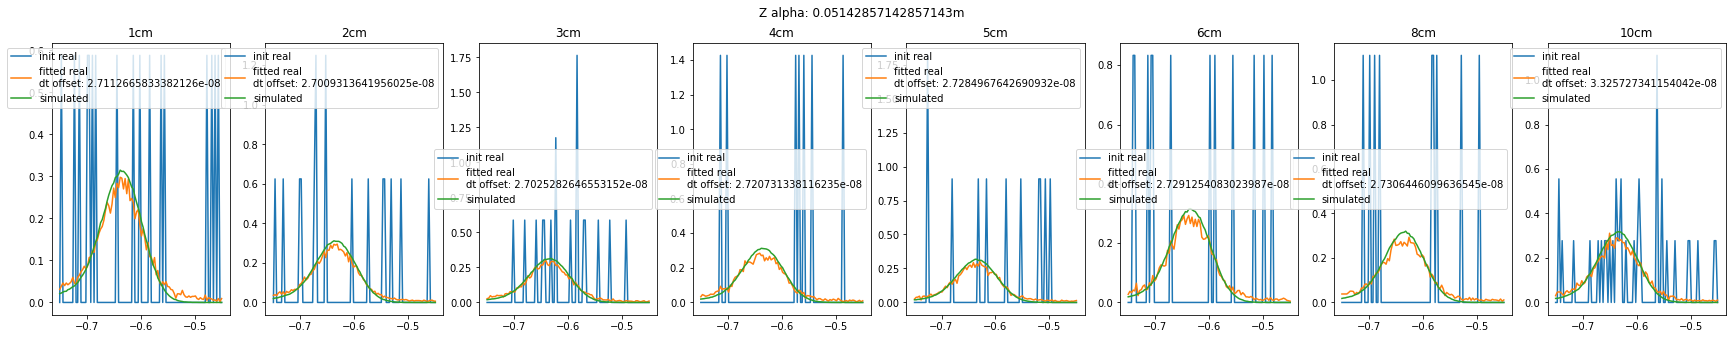

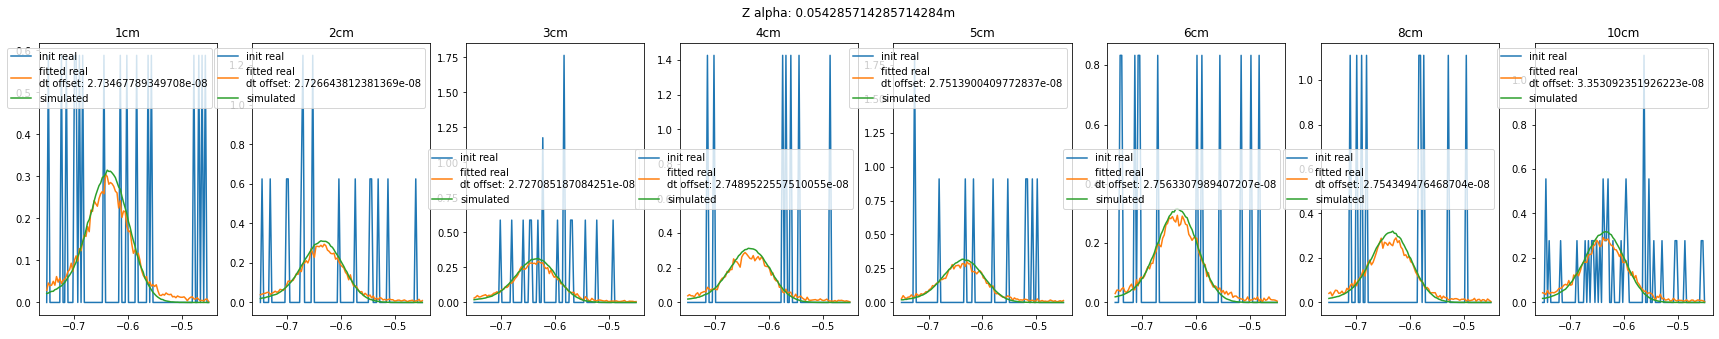

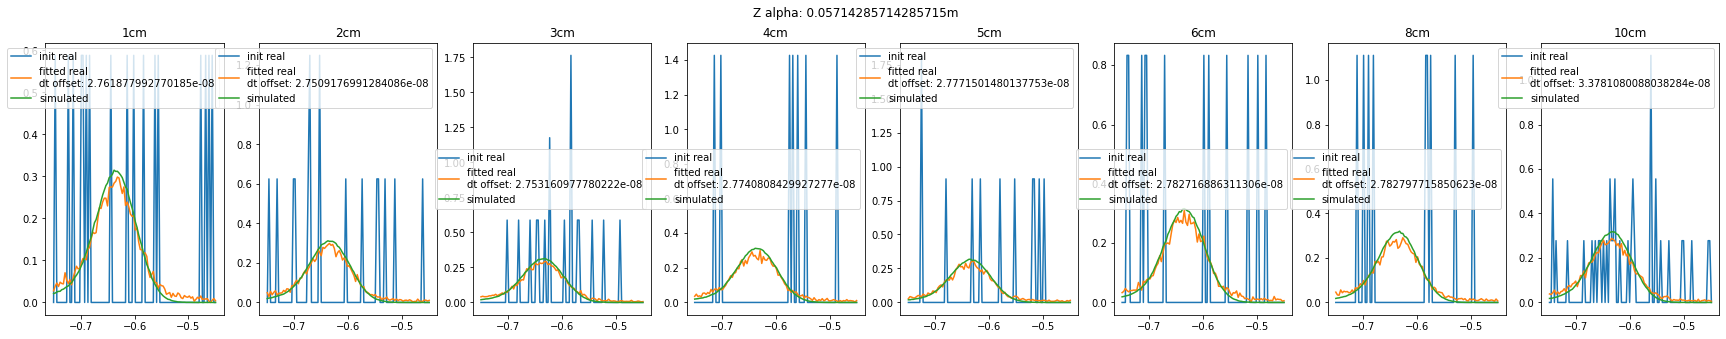

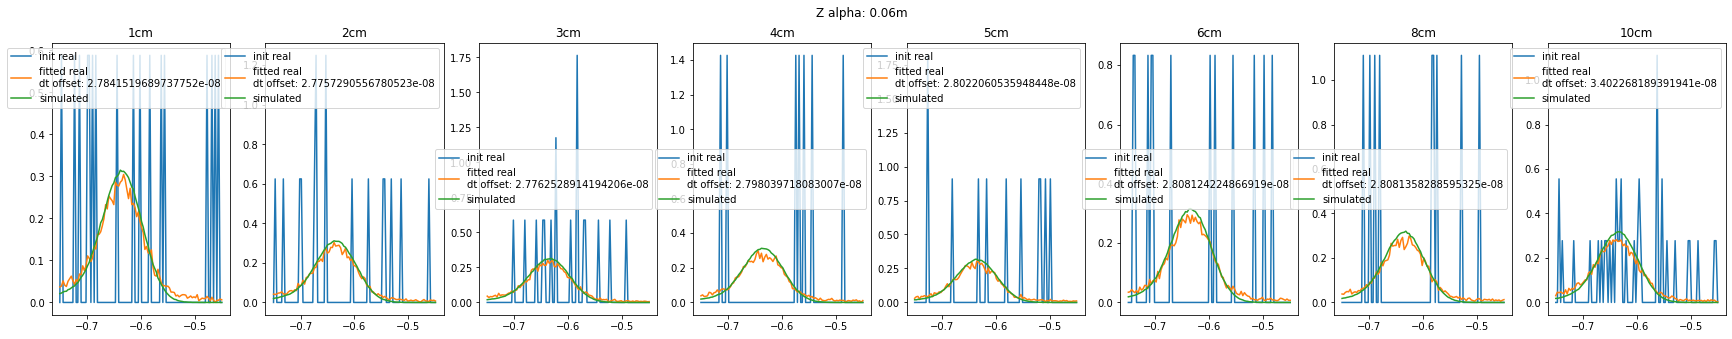

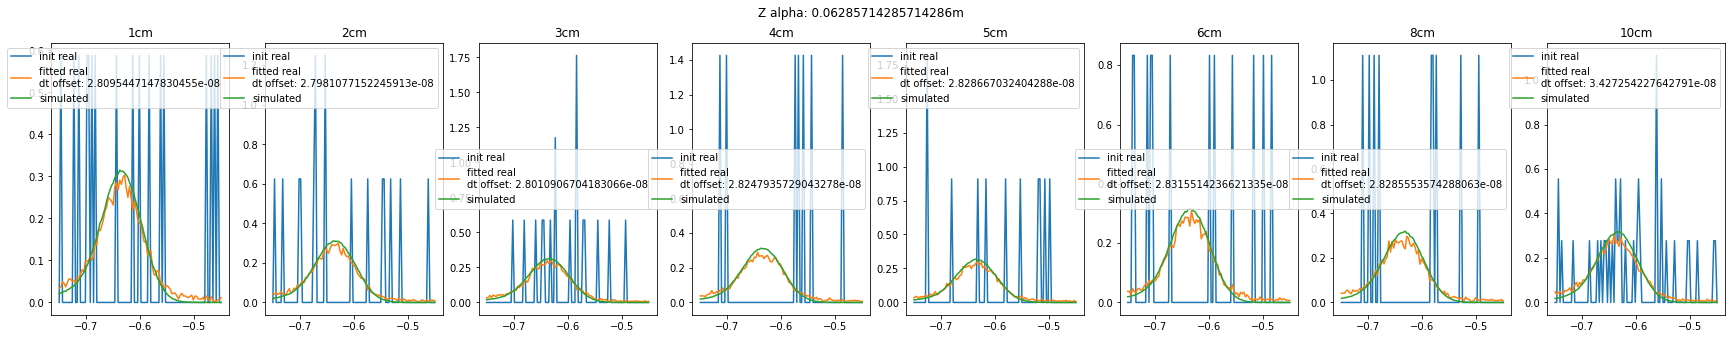

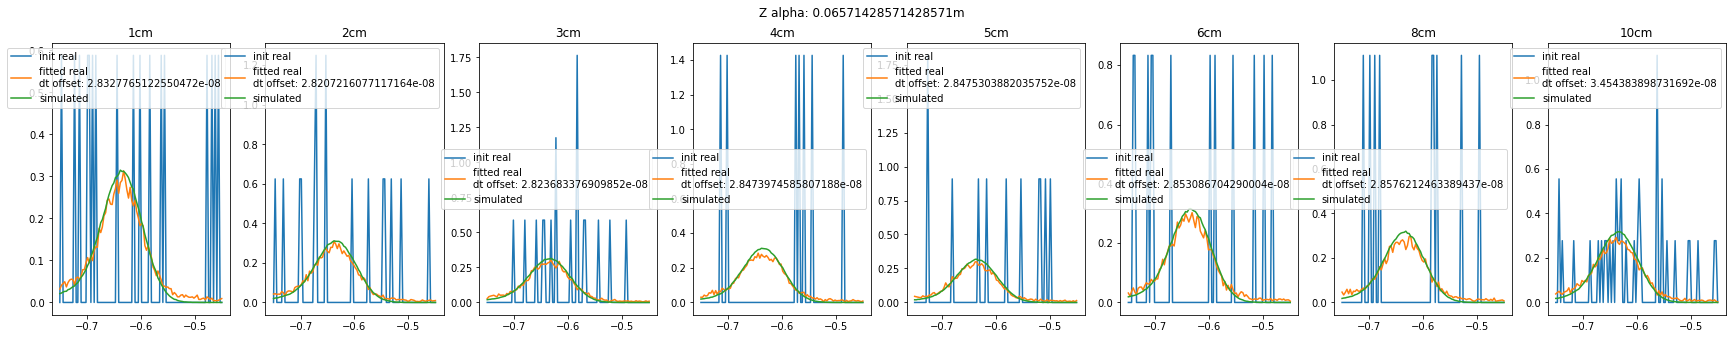

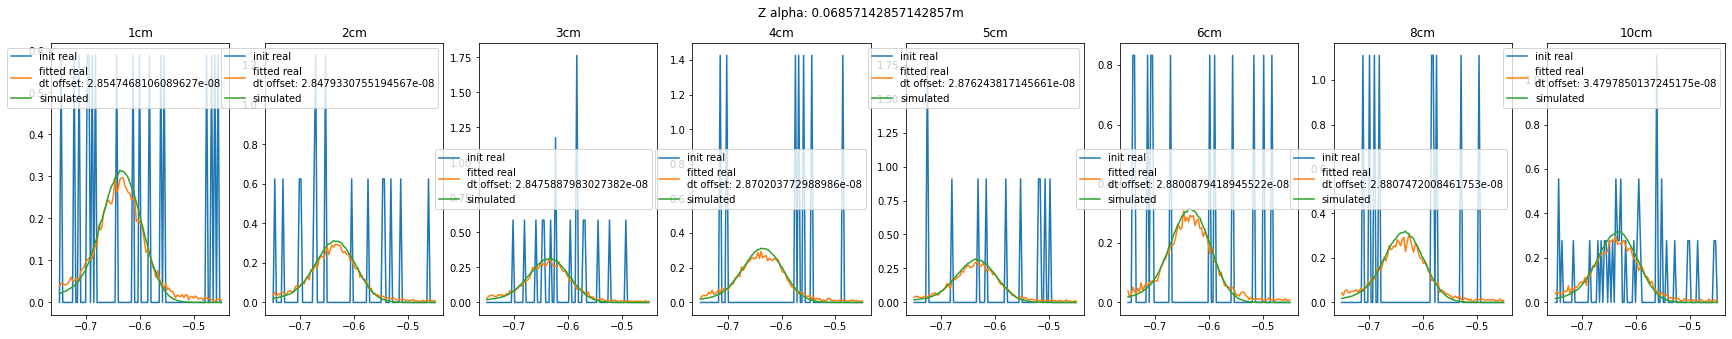

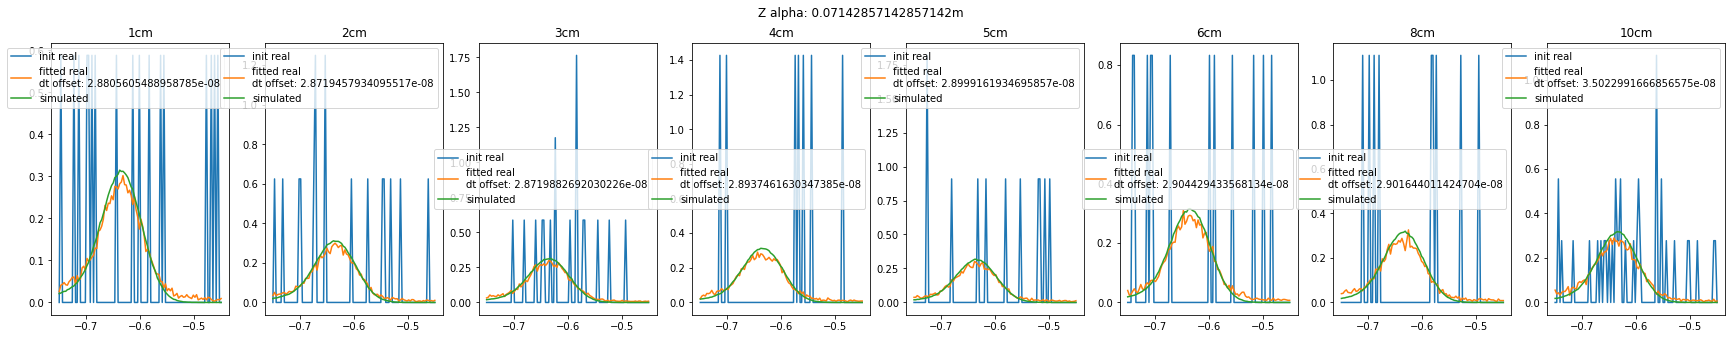

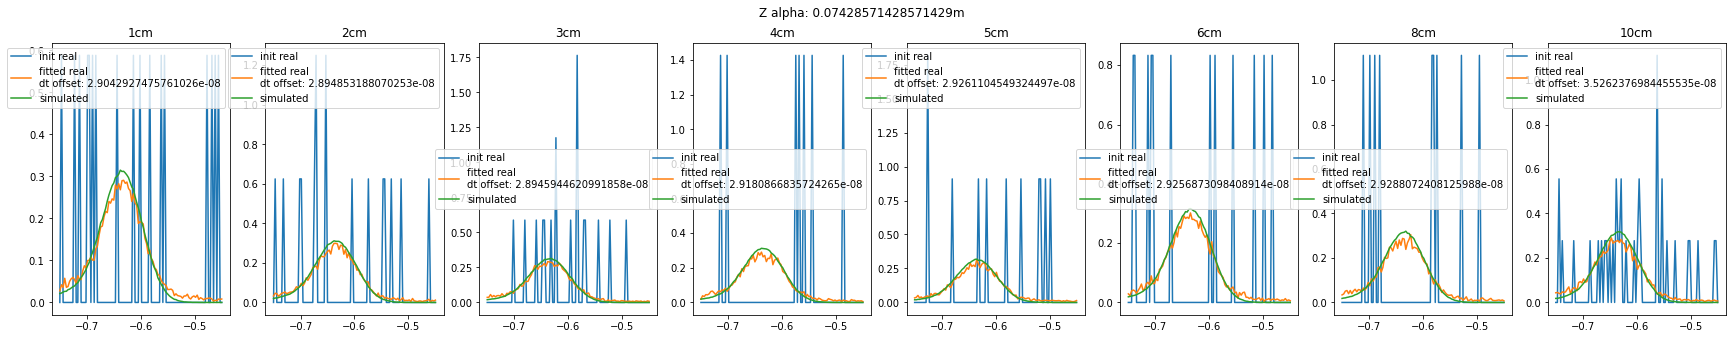

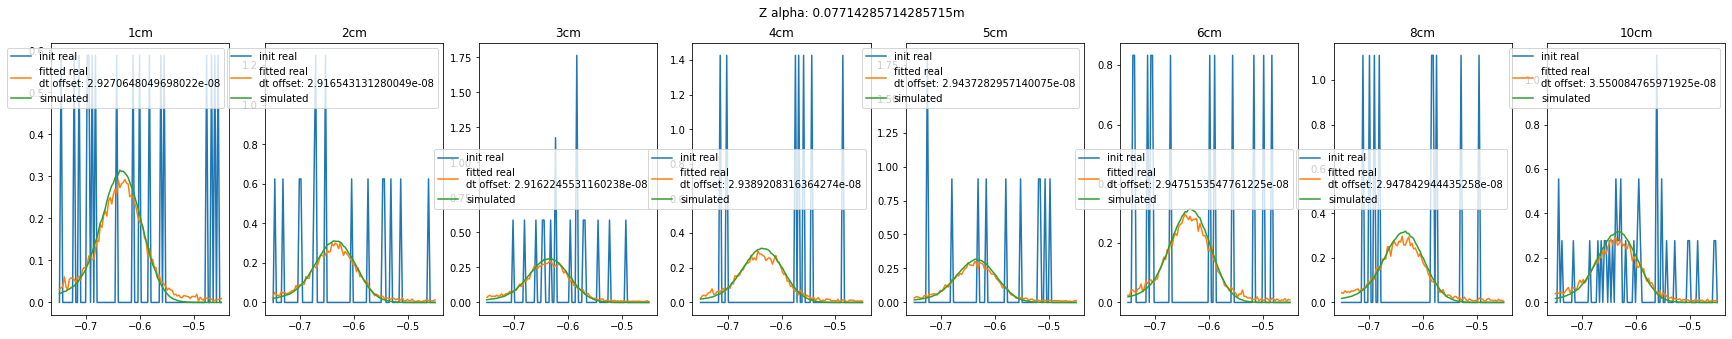

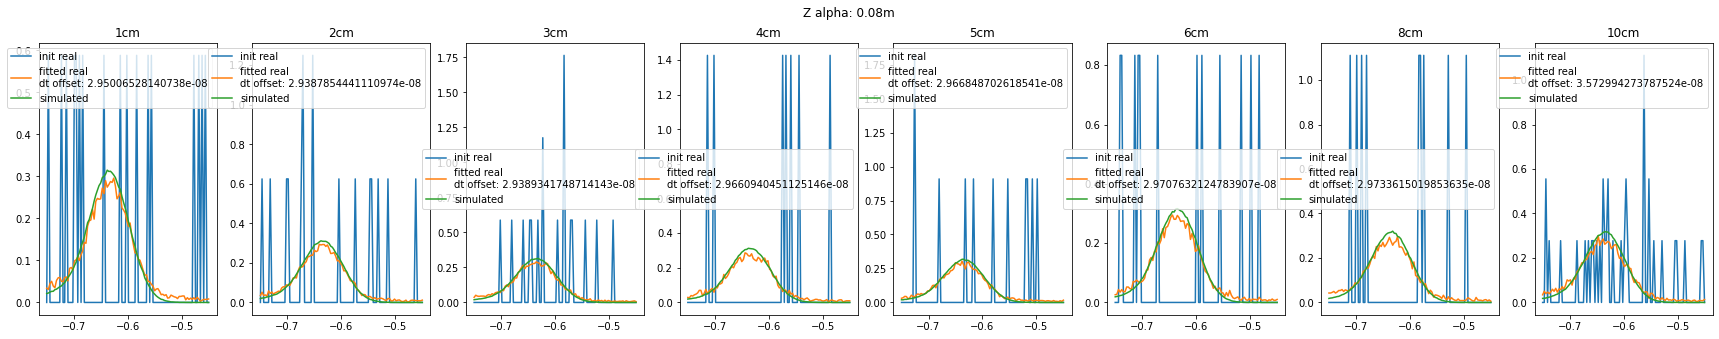

In [4]:
# we can use a slightly modified version of the loss function and target set we used in the fit real t offset/Z alpha to simulated data section


bins = 100
target_hists = {distance: RSI_utils.normalized_Z_hist(df, bins)[1] for distance, df in simulated_data.items()}

def residual(parameters, df, target_hist, Z_alpha):
    valuesdict = parameters.valuesdict()
    df = df.copy()
    df = RSI_utils.calcXYZ(df, t_offset_labr=valuesdict['t_offset'], Z_alpha=Z_alpha)
    _, model_hist = RSI_utils.normalized_Z_hist(df, bins)
    return target_hist - model_hist



# we know that the scintillator is supposed to sit 6cm away according to the design, and we can reasonably assume that there could be a >1cm error on that. Let's check values from 4cm to 7cm

n = 15
Z_alpha_series = np.linspace(0.04, 0.08, n)


# fit and save the resulting dt offsets

t_offsets = {distance: [] for distance in target_hists}
for Z_alpha in Z_alpha_series:
    fig, axs = plt.subplots(1, len(target_hists), figsize=(30, 5))
    for (distance, real_df, target_hist), ax in zip(common_entries(real_data, target_hists), axs):
        params = lmfit.Parameters()
        t_offset_min = 2.5e-8
        t_offset_max = 3.1e-8 if distance <= 8 else 3.6e-8
        params.add('t_offset', value=3e-8, min=t_offset_min, max=t_offset_max)
        out = lmfit.minimize(residual, params, method='differential_evolution', args=(real_df, target_hist, Z_alpha))
        t_offset = out.params.valuesdict()['t_offset']
        t_offsets[distance].append(t_offset)
    
# uncomment to plot fits
#         fitted_df = real_df.copy()
#         fitted_df = RSI_utils.calcXYZ(fitted_df, t_offset_labr=t_offset, Z_alpha=Z_alpha)
#         Z_series, fitted_hist = RSI_utils.normalized_Z_hist(fitted_df, bins)
#         _, real_hist = RSI_utils.normalized_Z_hist(real_df, bins)
#         fitted_label = f'fitted real\ndt offset: {t_offset}'
#         for hist, label in zip((real_hist, fitted_hist, target_hist), ('init real', fitted_label, 'simulated')):
#             ax.plot(Z_series, hist, label=label)
#         ax.set_title(f'{distance}cm')
#         ax.legend()
#     fig.suptitle(f'Z alpha: {Z_alpha}m')

In [5]:
def calc_t_offset_function_factory(Z_alphas, observed_dts):
    a, b, c = np.polyfit(Z_alphas, observed_dts, 2)
    
    def calc_t_offset(Z_alpha):
        return a*Z_alpha**2 + b*Z_alpha + c
    
    return calc_t_offset


calc_t_offset_functions = {distance: calc_t_offset_function_factory(Z_alpha_series, t_offset_list) for distance, t_offset_list in t_offsets.items()}

# Fit the the distance to the scintillator directly to the simulated Y hist (with some shifts in real Y alpha)

In [6]:
# We want to fit the simulated data to the Y hists of the real data. Now our domain set is the simulated data
# Let's create our target set (Y histograms of the real data)

bins = 100


# define our loss function

def residual(parameters, real_dfs, simulated_dfs, offset_funcs):
    valuesdict = parameters.valuesdict()
    resids = []
    for distance, real_df, simulated_df, offset_func in common_entries(real_dfs, simulated_dfs, offset_funcs):
        # apply parameters to simulated data
        simulated_df = simulated_df.copy()
        simulated_df['Y_alpha'] = RSI_utils.add_noise(simulated_df['Y_alpha'], valuesdict['sigma'])
        simulated_df['Y_alpha'] = simulated_df['Y_alpha'] + valuesdict[f'Y_alpha_offset_{distance}']
        simulated_df = RSI_utils.calcXYZ(simulated_df, t_offset_labr=0, Z_alpha=0.06)
        _, simulated_hist = RSI_utils.normalized_Y_hist(simulated_df, bins)
        # apply parameters to real data
        real_df = real_df.copy()
        t_offset = offset_func(valuesdict['Z_alpha'])
        real_df = RSI_utils.calcXYZ(real_df, t_offset_labr=t_offset, Z_alpha=valuesdict['Z_alpha'])
        Z_series, real_hist = RSI_utils.normalized_Y_hist(real_df, bins)
        resids.append(np.abs(real_hist - simulated_hist))
    resids = np.concatenate(resids)
    return resids

In [7]:
# fit data

Y_alpha_offsets = {
    1: 0.002,
    2: 0.002,
    3: 0.0015,
    4: 0.0015,
    5: 0.0015,
    6: 0.0015,
    8: 0.0015,
    10: 0.002
}

params = lmfit.Parameters()
params.add('sigma', value=0.0025, min=0.0015, max=0.003)
params.add('Z_alpha', value=0.067, min=0.06, max=0.075)
for distance, init_value in Y_alpha_offsets.items():
    params.add(f'Y_alpha_offset_{distance}', value=init_value, min=init_value-0.001, max=init_value+0.001, vary=False)

out = lmfit.minimize(residual, params, method='differential_evolution', args=(real_data, simulated_data, calc_t_offset_functions), epsfcn=0.0001)
# out = lmfit.minimize(residual, params, args=(real_data, simulated_data, calc_t_offset_functions), epsfcn=0.0001)


# Plot results

In [8]:
from matplotlib import pyplot as plt

%matplotlib

Using matplotlib backend: MacOSX


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from fast_histogram import histogram1d, histogram2d

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

raw_simulated_data = RSI_utils.load_data(simulated_data_dir)
raw_simulated_data = {distance: RSI_utils.calcXYZ(raw_simulated_data[distance], t_offset_labr=0, Z_alpha=0.06) for distance in real_data}

distance = 8

valuesdict = out.params.valuesdict()
sigma = valuesdict['sigma']
Z_alpha = valuesdict['Z_alpha']
real_df = real_data[distance]
simulated_df = simulated_data[distance]
calc_t_offset = calc_t_offset_functions[distance]


fitted_simulated_df = simulated_df.copy()
fitted_simulated_df['Y_alpha'] = RSI_utils.add_noise(fitted_simulated_df['Y_alpha'], sigma)
fitted_simulated_df['Y_alpha'] = fitted_simulated_df['Y_alpha'] + valuesdict[f'Y_alpha_offset_{distance}']
fitted_simulated_df = RSI_utils.calcXYZ(fitted_simulated_df, t_offset_labr=0, Z_alpha=0.06)

fitted_real_df = real_df.copy()
t_offset = calc_t_offset(Z_alpha)
fitted_real_df = RSI_utils.calcXYZ(fitted_real_df, t_offset_labr=t_offset, Z_alpha=Z_alpha)

raw_simulated_df = raw_simulated_data[distance]

dim = 'Z'
hist_func = RSI_utils.normalized_Z_hist
ax = axs[0]
for df, label in zip((fitted_real_df, fitted_simulated_df, raw_simulated_df), ('Measurement', 'Simulation + Noise', 'Simulation')):
    x, hist = hist_func(df, bins)
    linestyle = 'dashed' if label == 'Simulation' else None
    ax.plot(100*x, hist, label=label, linestyle=linestyle)
ax.legend()
ax.set_title(f'{distance} cm')
ax.set_xlabel(f'{dim} [cm]')
ax.set_ylabel('Counts [a.u.]')


dim = 'Y'
hist_func = RSI_utils.normalized_Y_hist
ax = axs[1]
for df, label in zip((fitted_real_df, fitted_simulated_df, raw_simulated_df), ('Measurement', 'Simulation + Noise', 'Simulation')):
    x, hist = hist_func(df, bins)
    linestyle = 'dashed' if label == 'Simulation' else None
    ax.plot(100*x, hist, label=label, linestyle=linestyle)
ax.set_title(f'{distance} cm')
ax.set_xlabel(f'{dim} [cm]')
ax.set_ylabel('Counts [a.u.]')

axins = inset_axes(ax, width='30%', height='40%', loc='upper right')
data = RSI_utils.cut_out_cube(fitted_real_df, RSI_utils.position_lims['X'], RSI_utils.position_lims['Y'], RSI_utils.position_lims['Z'])
result = histogram2d(data['X'], data['Y'], 100, range=[RSI_utils.position_lims['X'], RSI_utils.position_lims['Y']])
axins.imshow(
    result,
    aspect="auto",
#             extent=extent,
    interpolation="bilinear",
    cmap="inferno",
    vmax=None,
)
axins.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
axins.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False) 

distance = 4
ax = axs[2]

valuesdict = out.params.valuesdict()
sigma = valuesdict['sigma']
Z_alpha = valuesdict['Z_alpha']
real_df = real_data[distance]
simulated_df = simulated_data[distance]
calc_t_offset = calc_t_offset_functions[distance]


fitted_simulated_df = simulated_df.copy()
fitted_simulated_df['Y_alpha'] = RSI_utils.add_noise(fitted_simulated_df['Y_alpha'], sigma)
fitted_simulated_df['Y_alpha'] = fitted_simulated_df['Y_alpha'] + valuesdict[f'Y_alpha_offset_{distance}']
fitted_simulated_df = RSI_utils.calcXYZ(fitted_simulated_df, t_offset_labr=0, Z_alpha=0.06)

fitted_real_df = real_df.copy()
t_offset = calc_t_offset(Z_alpha)
fitted_real_df = RSI_utils.calcXYZ(fitted_real_df, t_offset_labr=t_offset, Z_alpha=Z_alpha)
dim = 'Y'
hist_func = RSI_utils.normalized_Y_hist

fig = plt.figure(figsize=(5, 5))
for df, label in zip((fitted_real_df, fitted_simulated_df), ('Measured', 'Simulated')):
    x, hist = hist_func(df, bins)
    ax.plot(100*x, hist, label=label)
#         plt.legend()
ax.set_title(f'{distance} cm')
ax.set_xlabel(f'{dim} [cm]')
ax.set_ylabel('Counts [a.u.]')
axins = inset_axes(ax, width='30%', height='40%', loc='upper right')
data = RSI_utils.cut_out_cube(fitted_real_df, RSI_utils.position_lims['X'], RSI_utils.position_lims['Y'], RSI_utils.position_lims['Z'])
result = histogram2d(data['X'], data['Y'], 100, range=[RSI_utils.position_lims['X'], RSI_utils.position_lims['Y']])
axins.imshow(
    result,
    aspect="auto",
#             extent=extent,
    interpolation="bilinear",
    cmap="inferno",
    vmax=None,
)
axins.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
axins.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False) 


distance = 2
ax = axs[3]

valuesdict = out.params.valuesdict()
sigma = valuesdict['sigma']
Z_alpha = valuesdict['Z_alpha']
real_df = real_data[distance]
simulated_df = simulated_data[distance]
calc_t_offset = calc_t_offset_functions[distance]


fitted_simulated_df = simulated_df.copy()
fitted_simulated_df['Y_alpha'] = RSI_utils.add_noise(fitted_simulated_df['Y_alpha'], sigma)
fitted_simulated_df['Y_alpha'] = fitted_simulated_df['Y_alpha'] + valuesdict[f'Y_alpha_offset_{distance}']
fitted_simulated_df = RSI_utils.calcXYZ(fitted_simulated_df, t_offset_labr=0, Z_alpha=0.06)

fitted_real_df = real_df.copy()
t_offset = calc_t_offset(Z_alpha)
fitted_real_df = RSI_utils.calcXYZ(fitted_real_df, t_offset_labr=t_offset, Z_alpha=Z_alpha)
dim = 'Y'
hist_func = RSI_utils.normalized_Y_hist

fig = plt.figure(figsize=(5, 5))
for df, label in zip((fitted_real_df, fitted_simulated_df), ('Measured', 'Simulated')):
    x, hist = hist_func(df, bins)
    ax.plot(100*x, hist, label=label)
#         plt.legend()
ax.set_title(f'{distance} cm')
ax.set_xlabel(f'{dim} [cm]')
ax.set_ylabel('Counts [a.u.]')
axins = inset_axes(ax, width='30%', height='40%', loc='upper right')
data = RSI_utils.cut_out_cube(fitted_real_df, RSI_utils.position_lims['X'], RSI_utils.position_lims['Y'], RSI_utils.position_lims['Z'])
result = histogram2d(data['X'], data['Y'], 100, range=[RSI_utils.position_lims['X'], RSI_utils.position_lims['Y']])
axins.imshow(
    result,
    aspect="auto",
#             extent=extent,
    interpolation="bilinear",
    cmap="inferno",
    vmax=None,
)
axins.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
axins.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False) 
fig.show()